# Zero-Inflated Poisson Regression

# Imports

In [13]:
from xgboostlss.model import *
from xgboostlss.distributions.ZIPoisson import *

from sklearn.model_selection import train_test_split
import pandas as pd
import multiprocessing
import plotnine
from plotnine import *
plotnine.options.figure_size = (18, 9)
n_cpu = multiprocessing.cpu_count()

# Data

In [2]:
# For more information on the dataset see: https://stats.oarc.ucla.edu/stata/dae/zero-inflated-poisson-regression/
data = pd.read_stata("http://www.stata-press.com/data/r10/fish.dta")
y = data["count"].values.reshape(-1,1)
X = data.drop(columns="count")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

dtrain = xgb.DMatrix(X_train, label=y_train, nthread=n_cpu)
dtest = xgb.DMatrix(X_test, nthread=n_cpu)

# Distribution Selection

In [3]:
# Specifies Zero-Inflated Poisson distribution. See ?ZIPoisson for an overview.
xgblss = XGBoostLSS(
    ZIPoisson(stabilization="None",      # Options are "None", "MAD", "L2".
              response_fn="softplus",    # Function to transform the scale-parameter, e.g., "exp" or "softplus".
              loss_fn="nll"              # Loss function. Options are "nll" (negative log-likelihood) or "crps"(continuous ranked probability score).
             )    
)

# Hyper-Parameter Optimization

In [4]:
# Any XGBoost hyperparameter can be tuned, where the structure of the parameter dictionary needs to be as follows:

    # Float/Int sample_type
        # {"param_name": ["sample_type", low, high, log]}
            # sample_type: str, Type of sampling, e.g., "float" or "int"
            # low: int, Lower endpoint of the range of suggested values
            # high: int, Upper endpoint of the range of suggested values
            # log: bool, Flag to sample the value from the log domain or not
        # Example: {"eta": "float", low=1e-5, high=1, log=True]}

    # Categorical sample_type
        # {"param_name": ["sample_type", ["choice1", "choice2", "choice3", "..."]]}
            # sample_type: str, Type of sampling, either "categorical"
            # choice1, choice2, choice3, ...: str, Possible choices for the parameter
        # Example: {"booster": ["categorical", ["gbtree", "dart"]]}

    # For parameters without tunable choice (this is needed if tree_method = "gpu_hist" and gpu_id needs to be specified)
        # {"param_name": ["none", [value]]},
            # param_name: str, Name of the parameter
            # value: int, Value of the parameter
        # Example: {"gpu_id": ["none", [0]]}

# Depending on which parameters are optimized, it might happen that some of them are not used, e.g., when {"booster":  ["categorical", ["gbtree", "gblinear"]]} and {"max_depth": ["int", 1, 10, False]} are
# specified, max_depth is not used when gblinear is sampled, since it has no such argument.

param_dict = {
    "eta":              ["float", {"low": 1e-5,   "high": 1,     "log": True}],
    "max_depth":        ["int",   {"low": 1,      "high": 10,    "log": False}],
    "gamma":            ["float", {"low": 1e-8,   "high": 40,    "log": True}],
    "subsample":        ["float", {"low": 0.2,    "high": 1.0,   "log": False}],
    "colsample_bytree": ["float", {"low": 0.2,    "high": 1.0,   "log": False}],
    "booster":          ["categorical", ["gbtree"]],
    # "tree_method":    ["categorical", ["auto", "approx", "hist", "gpu_hist"]],
    # "gpu_id":         ["none", [0]]
}

np.random.seed(123)
opt_param = xgblss.hyper_opt(param_dict,
                             dtrain,
                             num_boost_round=100,        # Number of boosting iterations.
                             nfold=5,                    # Number of cv-folds.
                             early_stopping_rounds=20,   # Number of early-stopping rounds
                             max_minutes=5,              # Time budget in minutes, i.e., stop study after the given number of minutes.
                             n_trials=None,              # The number of trials. If this argument is set to None, there is no limitation on the number of trials.
                             silence=False,              # Controls the verbosity of the trail, i.e., user can silence the outputs of the trail.
                             seed=123,                   # Seed used to generate cv-folds.
                             hp_seed=None                # Seed for random number generator used in the Bayesian hyperparameter search.
                            )

[I 2023-06-14 11:14:45,252] A new study created in memory with name: XGBoostLSS Hyper-Parameter Optimization
C:\Users\maerzale\.virtualenvs\XGBoostLSS-vIPRRz-M\lib\site-packages\optuna\progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


   0%|          | 00:00/05:00

[I 2023-06-14 11:14:53,422] Trial 0 finished with value: 125.09651720000002 and parameters: {'eta': 0.014973461590179104, 'max_depth': 2, 'gamma': 2.326683929144988e-08, 'subsample': 0.5349311436441597, 'colsample_bytree': 0.6314164634002168, 'booster': 'gbtree'}. Best is trial 0 with value: 125.09651720000002.
[I 2023-06-14 11:14:58,865] Trial 1 finished with value: 184.09348740000001 and parameters: {'eta': 0.0003337939832841704, 'max_depth': 8, 'gamma': 2.236013271795785, 'subsample': 0.916582073610644, 'colsample_bytree': 0.4474254833596454, 'booster': 'gbtree'}. Best is trial 0 with value: 125.09651720000002.
[I 2023-06-14 11:15:04,232] Trial 2 finished with value: 186.5003694 and parameters: {'eta': 4.0339279936012137e-05, 'max_depth': 6, 'gamma': 0.006936460045386577, 'subsample': 0.7191621252907974, 'colsample_bytree': 0.36721779044009245, 'booster': 'gbtree'}. Best is trial 0 with value: 125.09651720000002.
[I 2023-06-14 11:15:06,184] Trial 3 finished with value: 72.4170190000

# Model Training

In [5]:
np.random.seed(123)

opt_params = opt_param.copy()
n_rounds = opt_params["opt_rounds"]
del opt_params["opt_rounds"]

# Train Model with optimized hyperparameters
xgblss.train(opt_params,
             dtrain,
             num_boost_round=n_rounds
             )

# Prediction

In [6]:
# Set seed for reproducibility
torch.manual_seed(123)

# Number of samples to draw from predicted distribution
n_samples = 1000
# Quantiles to calculate from predicted distribution
quant_sel = [0.05, 0.95] 

# Sample from predicted distribution
pred_samples = xgblss.predict(dtest,
                              pred_type="samples",
                              n_samples=n_samples,
                              seed=123)

# Calculate quantiles from predicted distribution
pred_quantiles = xgblss.predict(dtest,
                                pred_type="quantiles",
                                n_samples=n_samples,
                                quantiles=quant_sel)

# Returns predicted distributional parameters
pred_params = xgblss.predict(dtest,
                             pred_type="parameters")

In [7]:
pred_samples.head()

,y_sample0,y_sample1,y_sample2,y_sample3,y_sample4,y_sample5,y_sample6,y_sample7,y_sample8,y_sample9,...,y_sample990,y_sample991,y_sample992,y_sample993,y_sample994,y_sample995,y_sample996,y_sample997,y_sample998,y_sample999
0,7,5,8,4,8,3,7,0,4,4,...,10,8,4,5,8,6,2,5,7,6
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,31,20,20,25,32,25,37,15,36,25,...,32,35,29,30,27,35,37,28,38,35
3,32,40,32,27,17,23,40,37,33,35,...,35,27,47,31,36,31,38,37,23,29
4,0,0,1,2,2,0,1,1,0,1,...,1,2,1,4,1,2,0,2,1,0


In [8]:
pred_quantiles.head()

,quant_0.05,quant_0.95
0,2,10
1,0,0
2,19,37
3,23,41
4,0,3


In [9]:
pred_params.head()

,rate,gate
0,5.538337,0.006135
1,0.020181,0.970370
2,27.415279,0.002903
3,31.826422,0.002903
4,1.099692,0.012614


# SHAP Interpretability

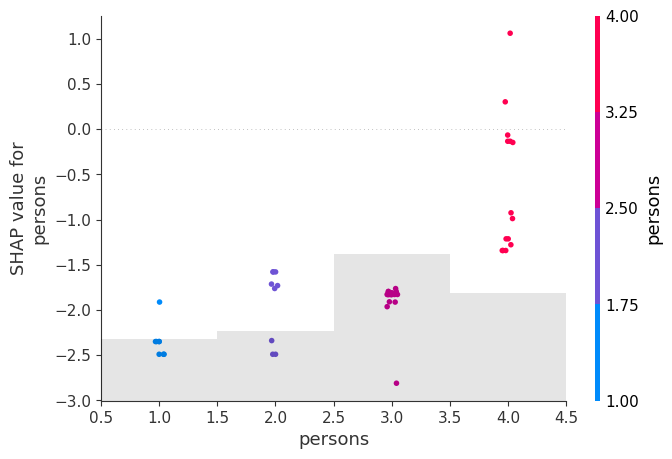

In [10]:
# Partial Dependence Plot of rate parameter
xgblss.plot(X_test,
            parameter="rate",
            feature="persons",
            plot_type="Partial_Dependence")

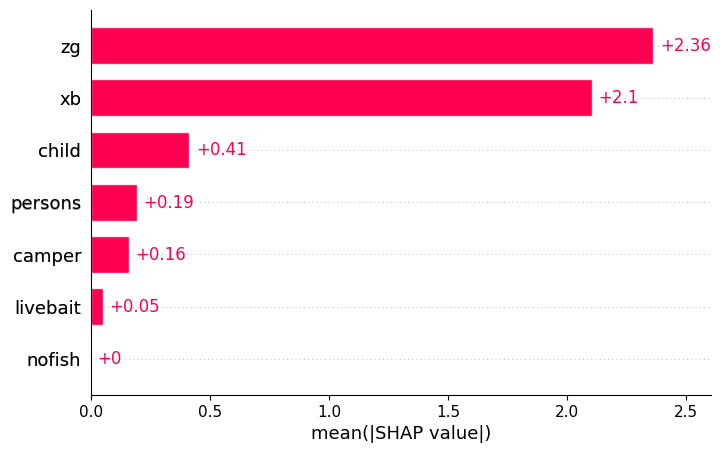

In [11]:
# Feature Importance of gate parameter
xgblss.plot(X_test,
            parameter="gate",
            plot_type="Feature_Importance")

# Density Plots of Actual and Predicted Samples

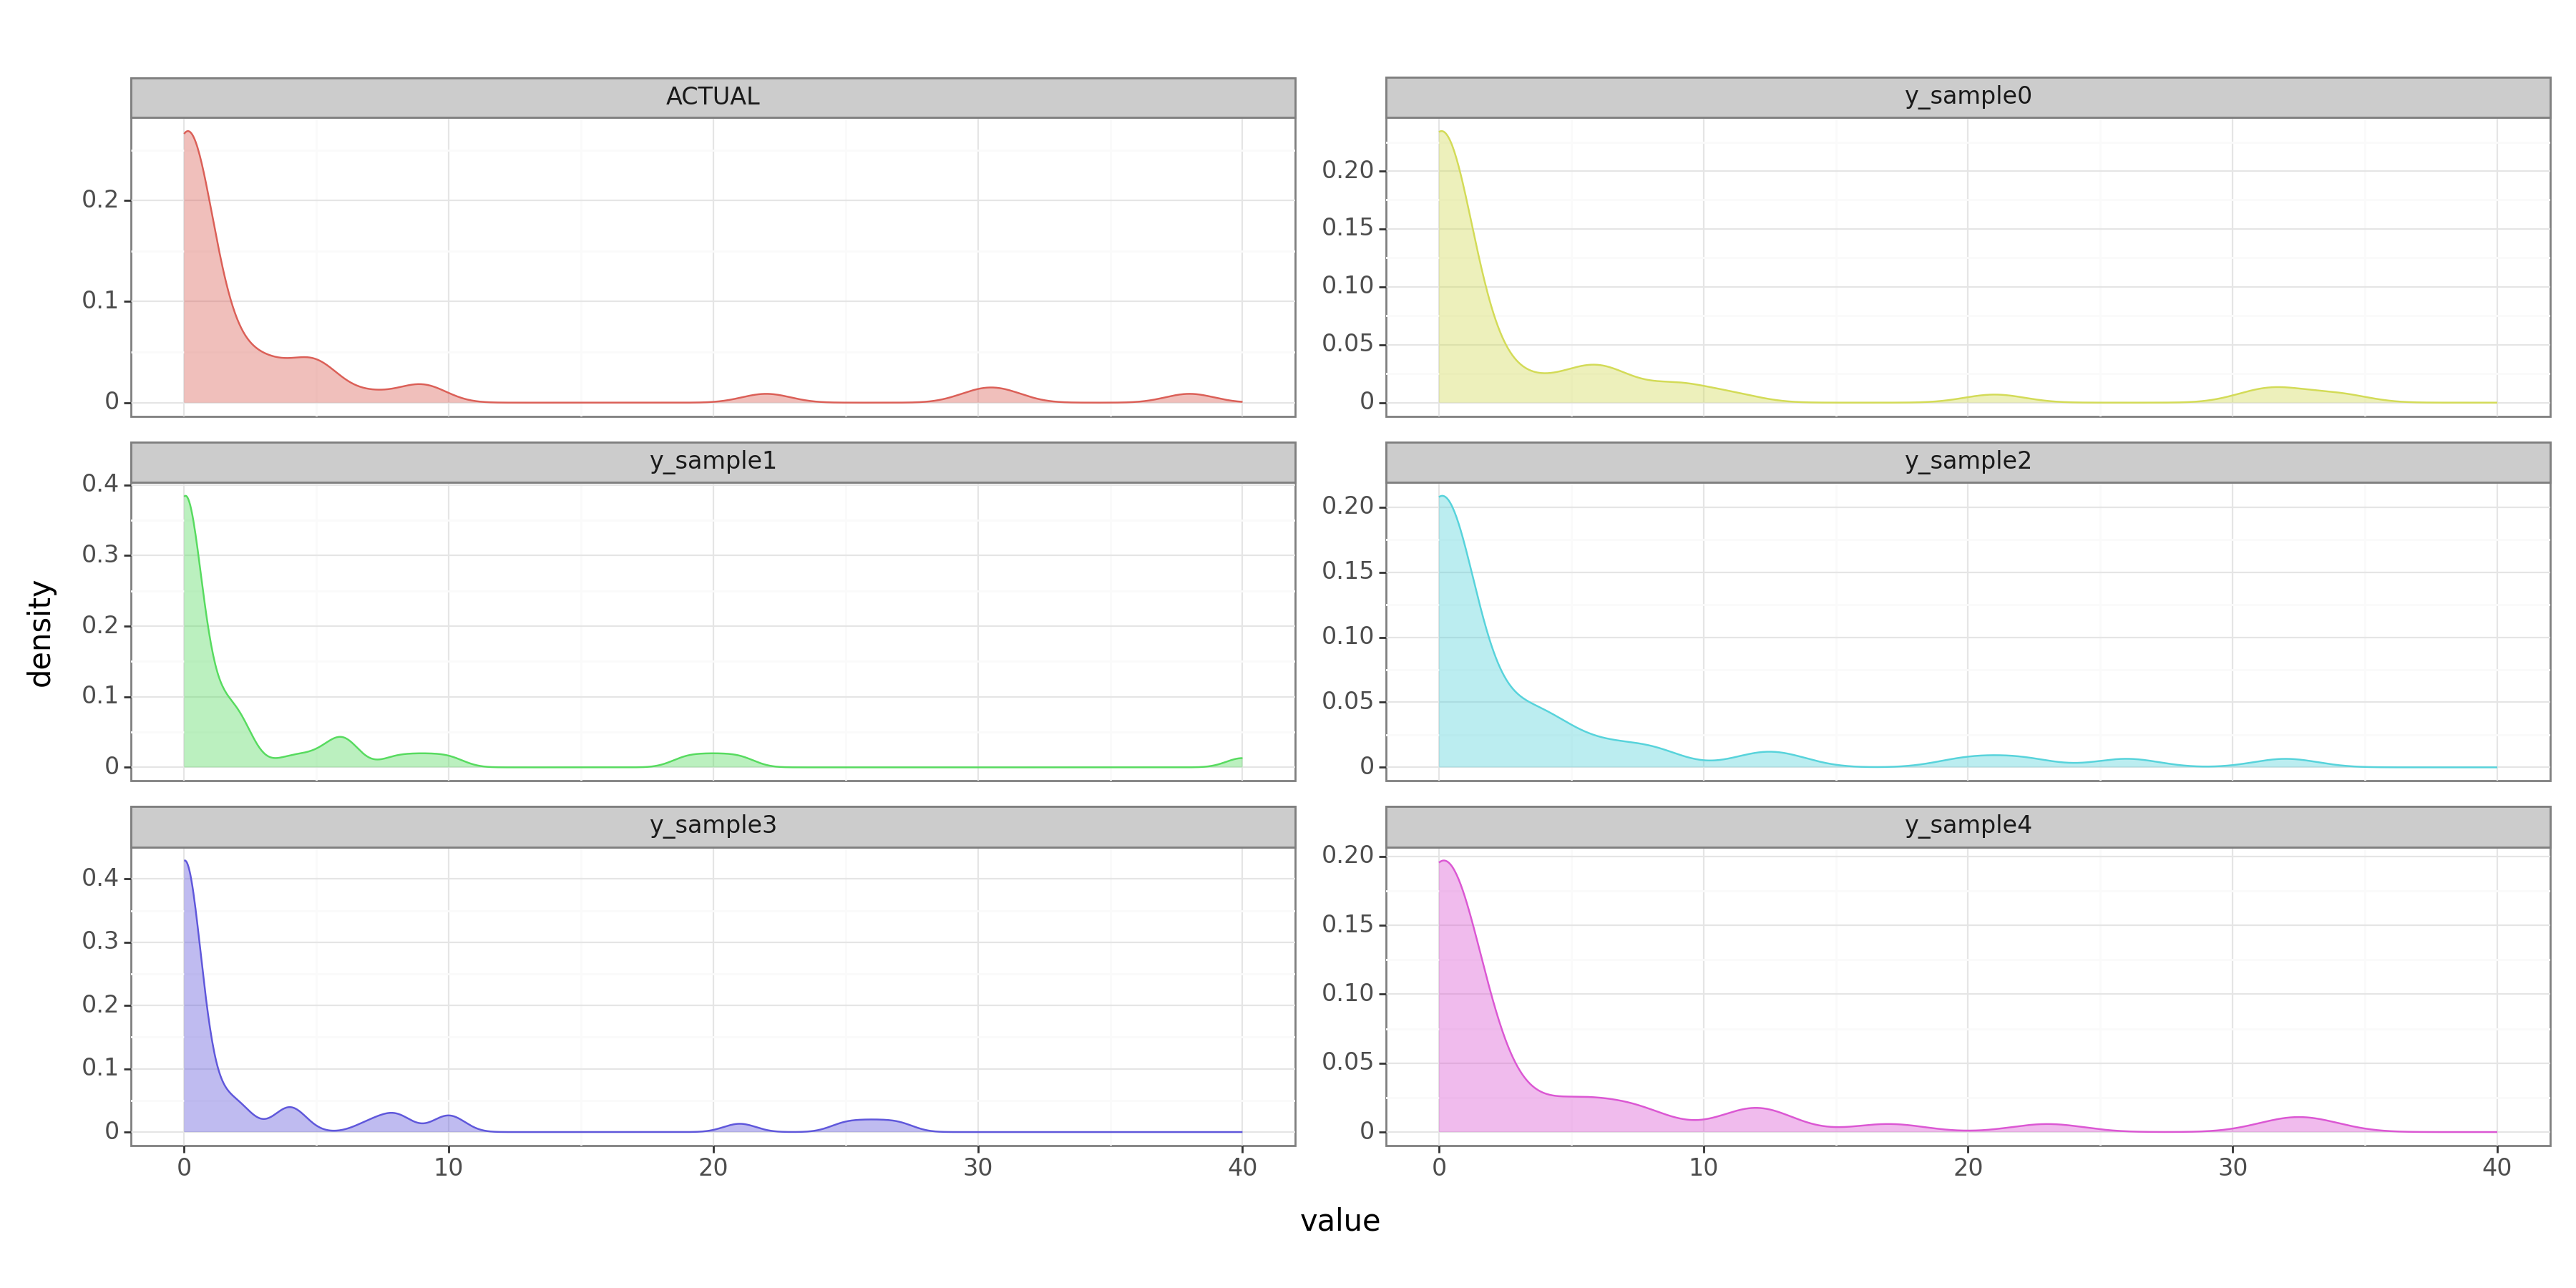

<Figure Size: (1800 x 900)>

In [12]:
pred_df = pd.melt(pred_samples.iloc[:,0:5])
actual_df = pd.DataFrame.from_dict({"variable": "ACTUAL", "value": y_test.reshape(-1,)})
plot_df = pd.concat([pred_df, actual_df])

(
    ggplot(plot_df, 
           aes(x="value",
               color="variable",
               fill="variable")) +  
    geom_density(alpha=0.4) + 
    facet_wrap("variable",
              scales="free_y",
              ncol=2) + 
    theme_bw(base_size=15) + 
    theme(legend_position="none")
)